<a href="https://colab.research.google.com/github/ucheokechukwu/zero_to_mastery_courses/blob/main/Pytorch_For_Deep_Learning/01_workflow_fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
what_were_covering = {1: "data (prepare and load)",
                      2: "build model",
                      3: "fitting the model to data (training)",
                      4: "making predictions and evaluating the model (inferences)",
                      5: "saving and loading a model",
                      6: "putting it all together"}


In [2]:
import torch
from torch import nn # building blocks of graphs (neural networks)
import matplotlib.pyplot as plt

# check pytorch version
torch.__version__

'2.0.1+cu118'

In [3]:
!nvidia-smi

Wed Aug  2 15:00:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# create *known* parameters
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [5]:
# splitting the data into training and sets
train_split = int(0.8*len(X))
X_train, y_train, X_test, y_test = X[:train_split], y[:train_split], X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [6]:
def plot_predictions(train_data = X_train,
                     train_label = y_train,
                     test_data = X_test,
                     test_label = y_test,
                     predictions=None):
    """plots training data, test data, and compares predictions"""
    plt.figure(figsize=(10,7))
    plt.scatter(train_data, train_label, c= 'b', s=4, label="Training data")
    plt.scatter(test_data, test_label, c= 'g', s=4, label="Testing data")


    if predictions is not None:
        plt.scatter(test_data, predictions, c= 'r', s=4, label="Predictions")

    plt.legend(prop={'size':14})

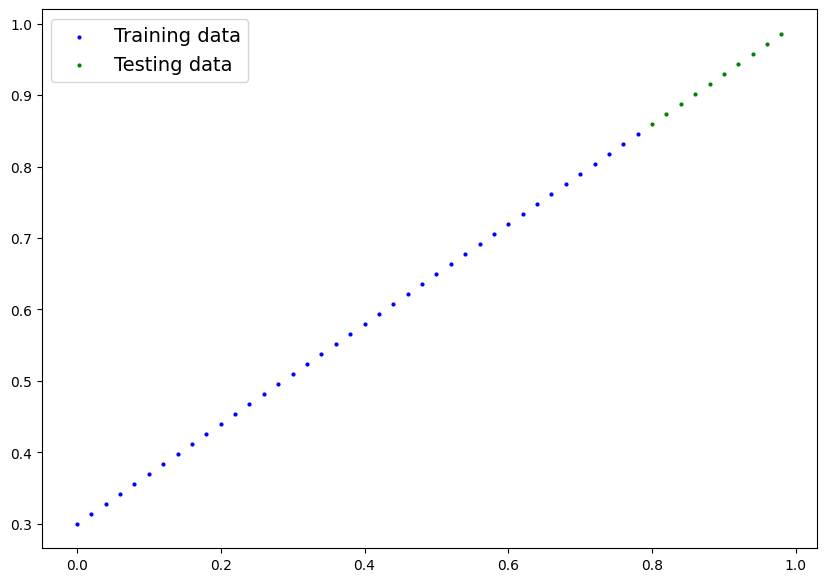

In [7]:
plot_predictions()

# 2. Build Model

What our model does:
1. starts with random values (weight and bias),
2. look at training data nad adjust the random values to better represent the ideal values (i.e. weight and biase used to create data)

how does it do so? 2 main algorithms:
1. gradient descent
2. back propagations

In [8]:
from torch import nn
# create a linear regression model class

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()

        # initialize the model parameters (could be single parameters, layers or functions)
        self.weights = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=torch.float))

    # forward method to define the computation in the model
    # need to override the forward method of nn.Module
    def forward(self, x:torch.Tensor) -> torch.Tensor:  # input is x of type torch.Tensor and returns type torch.Tensor
        return self.weights * x + self.bias


### pytorch model building essentials

* `torch.nn` - contains building blocks for computational graphs (neural networks)
* `torch.nn.Parameter` - parameters for the model to try and learn
* `torch.nn.Module` - base class
* `def forward` - all nn.Module submodules requre you to overwrite this
* `torch.optim `- optimizers, help with gradient descent
* `torch.utils.data.Dataset` - represents a map between key (label) and sample (features) pairs of data
* `torch.utils.data.Dataloader` - creates a python iterable over a torch Dataset (allows you to iterate over your data)


Pytorch cheat sheet: https://pytorch.org/tutorials/beginner/ptcheat.html


### checking the contents of the Pytorch model
- we can do this with `.parameters()`

In [9]:
# create a random seed
torch.manual_seed(88)

# create an instance of the model
model_0 = LinearRegressionModel()

# check out parameters
display(model_0.parameters()) # get a generator
list(model_0.parameters())

<generator object Module.parameters at 0x7db98704ad50>

[Parameter containing:
 tensor([0.5734], requires_grad=True),
 Parameter containing:
 tensor([1.3148], requires_grad=True)]

In [10]:
# list named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.5734])), ('bias', tensor([1.3148]))])

### making predictions using `torch.inference_mode()`

when we pass data through the model, it runs it through the `foward()` method

* inference mode turns off gradient tracking, which saves the data that Python is keeping track off, and makes predictions faster

In [11]:
# make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[1.7735],
        [1.7850],
        [1.7965],
        [1.8079],
        [1.8194],
        [1.8309],
        [1.8423],
        [1.8538],
        [1.8653],
        [1.8767]])

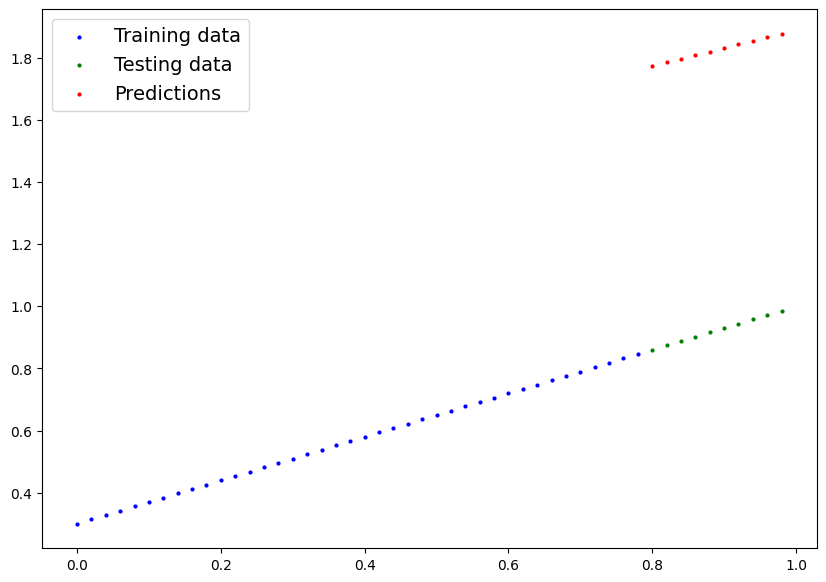

In [12]:
plot_predictions(predictions=y_preds)

### 3. train model

the idea of training is for model to move from a poor representation of the data to a better representation of the data.

one way to measure how poorly the model is predictign is to use a **loss functions** (also known as a **criterion** or **cost function**).

**Loss function**: how far model predictions are from ideal values (lower is better)

**Optimizer**: adjusts the model parameters (weights and biases) to improve loss function.

pytorch needs: training loop and testing loop.

In [13]:
# set up a loss function
loss_fn = nn.L1Loss() # mean absolute error

# set up optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) #lr -> learning rate

#### building a training loop (and a testing loop) in pytorch

0. loop throught the data
1. forward pass (involves data moving through our model's `forward` functions) also known as forward propagation
2. calculate the loss (compare forward pass predictions to ground truth labels)
3. optimizer zero grad
4. loss backward - move backwards through the network to calculate the gradient of each of the parameters of our model wrt to the loss
5. optimizer loss - use the optimizer to adjust the model's parameter to try and improve the loss (**gradient descent**)

In [14]:
# an epoch is one loop through the data

epochs = 1
### Training
# 0. loop through the data
for epoch in range(epochs):
    # set the model to training mode
    model_0.train()

    # 1. forward pass
    y_pred = model_0(X_train)
    # 2. calculate the loss
    loss = loss_fn(y_pred, y_train)
    # 3. optimizer zero grad
    optimizer.zero_grad()
    # 4. perform back propagation on the loss wrt parameters
    loss.backward()
    # 5. step the optimizer (perform gradient descent)
    optimizer.step()
    # how the optimizer changes accumulates through the loop so we have to zero it above